<hr>

<hr>

## 1. Eng-to-Ukr translation with a seq2seq Transformer

### Import of libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import string
import re
import numpy as np

import tensorflow as tf

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

### Preparing the data

In [2]:
with open("./ukr-eng/ukr.txt", "r", encoding = "utf-8") as f:
    lines = f.read().split("\n")[:-1]
    
text_pairs = []
for line in lines:
    eng, ukr, _ = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

for _ in range(5):
    print(random.choice(text_pairs))

('I refused to do so.', '[start] Я відмовився це робити. [end]')
('Tom is a slow eater.', '[start] Том повільно їсть. [end]')
("There's a secret passage.", '[start] Існує секретний прохід. [end]')
('Who gave you these glasses?', '[start] Хто вам дав ці окуляри? [end]')
("It's bedtime.", '[start] Час іти спати. [end]')


In [3]:
random.shuffle(text_pairs)
text_pairs = text_pairs[:100000]
num_val = int(0.15 * len(text_pairs))
num_train = len(text_pairs) - 2 * num_val
train_pairs = text_pairs[:num_train]
val_pairs = text_pairs[num_train : num_train + num_val]
test_pairs = text_pairs[num_train + num_val :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

100000 total pairs
70000 training pairs
15000 validation pairs
15000 test pairs


## Vectorizing the text data

In [4]:
strip_chars = string.punctuation.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocabulary_size = 15000
sequence_length = 20
batch_size = 64


def ukr_standardization(input_string):
    return tf.strings.regex_replace(tf.strings.lower(input_string), "[%s]" % re.escape(strip_chars), "")


eng_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

ukr_vector = keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=ukr_standardization,
)

train_eng = [pair[0] for pair in train_pairs]
train_ukr = [pair[1] for pair in train_pairs]
eng_vector.adapt(train_eng)
ukr_vector.adapt(train_ukr)

for v in [eng_vector, ukr_vector]:
    print(len(v.get_vocabulary()))
    print(v.get_vocabulary()[10:20])

8233
['do', 'im', 'have', 'was', 'me', 'mary', 'dont', 'in', 'he', 'it']
15000
['на', 'Мері', 'ти', 'Тома', 'я', 'з', 'у', 'Це', 'У', 'в']


In [5]:
def format_dataset(eng, ukr):
    eng = eng_vector(eng)
    ukr = ukr_vector(ukr)
    return ({ "encoder_inputs": eng, "decoder_inputs": ukr[:, :-1]}, ukr[:, 1:])

def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, targets in train_ds.take(1):
    print(f"inputs['encoder_inputs'].shape: {inputs['encoder_inputs'].shape}")
    print(f"inputs['decoder_inputs'].shape: {inputs['decoder_inputs'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['encoder_inputs'].shape: (64, 20)
inputs['decoder_inputs'].shape: (64, 20)
targets.shape: (64, 20)


### Building the model

* Filling of the seq2seq Transformer

In [6]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocabulary_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocabulary_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocabulary_size = vocabulary_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

* Assemble the end-to-end model

In [7]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocabulary_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model({"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
                          decoder_outputs, name="transformer",)

### Training our model

In [8]:
epochs = 5

transformer.summary()
transformer.compile("rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)   │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_inputs (InputLayer)   │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding          │ (None, None, 256)         │       3,845,120 │ encoder_inputs[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, None)              │               0 │ encoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding_1        │ (None, None, 256)         │       3,845,120 │ decoder_inputs[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder           │ (None, None, 256)         │       3,155,456 │ positional_embedding[0][0… │
│ (TransformerEncoder)          │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, None)              │               0 │ decoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_decoder           │ (None, None, 256)         │       5,259,520 │ positional_embedding_1[0]… │
│ (TransformerDecoder)          │                           │                 │ transformer_encoder[0][0], │
│                               │                           │                 │ not_equal_1[0][0],         │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, None, 256)         │               0 │ transformer_decoder[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, None, 15000)       │       3,855,000 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 938s 853ms/step - accuracy: 0.1605 - loss: 4.4434 - val_accuracy: 0.2059 - val_loss: 2.6559
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 957s 875ms/step - accuracy: 0.2037 - loss: 2.7136 - val_accuracy: 0.2195 - val_loss: 2.2275
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 950s 869ms/step - accuracy: 0.2194 - loss: 2.2820 - val_accuracy: 0.2283 - val_loss: 2.0763
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 998s 912ms/step - accuracy: 0.2282 - loss: 2.0780 - val_accuracy: 0.2286 - val_loss: 2.0596
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1041s 952ms/step - accuracy: 0.2342 - loss: 1.9674 - val_accuracy: 0.2327 - val_loss: 1.9851


### Decoding test sentences

In [9]:
ukr_vocab = ukr_vector.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vector([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vector([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
    return decoded_sentence
    
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

    print(f"<I>: {input_sentence}")
    print(f"<O>: {translated}")

<I>: Why don't you have any girlfriend?
<O>: [start] Чому в тебе немає друга дівчини [end]
<I>: I would like to meet her father.
<O>: [start] Я я хотіти зустріти батька [end]
<I>: He did his best to help him.
<O>: [start] Він сам круто допоміг [end]
<I>: She has a perfect body.
<O>: [start] Вона має досконалити [end]
<I>: Should I repeat this?
<O>: [start] Мені слід повтор це [end]



<hr>

<hr>

## 2. Use of pipeline module (Hugging Face)

In [10]:
from transformers import pipeline

* <u>Text generation</u>

In [11]:
generator = pipeline("text-generation", model="gpt2", device=0)
generated_text = generator(
    # Задайте початковий фрагмент тексту
    "Once upon a time, a professor of archaeology, Henry wanted",
    
    # Задайте бажану кількість GPT-слів 
    max_length=50,
    
    truncation=True,
    pad_token_id=50256,
    num_return_sequences=1,
)

print("\n<Generated text>:", generated_text[0]["generated_text"])

Device set to use cpu



<Generated text>: Once upon a time, a professor of archaeology, Henry wanted to show how it is that we can still live through the age of civilization despite having been "too little" or "too many" of which the majority are genetically determined to live in harmony.


* <u>Text translation</u>

In [12]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")
translated_text = translator(generated_text[0]["generated_text"])

print("\n<Translated text>:", translated_text[0]["translation_text"])

Device set to use cpu



<Translated text>: Давним-давно, професор археології, Генрі хотів показати, як це так, що ми все ще можемо прожити епоху цивілізації, незважаючи на те, що ми були "занадто мало" або "занадто багато", з яких більшість генетично визначена жити в злагоді.


<hr>

<hr>

## 3. Neural style transfer based on ImageNet

### Import of libraries

In [13]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

from IPython.display import Image, display
from tensorflow.keras.optimizers.schedules import ExponentialDecay

### The initial setup

In [14]:
base_image_path = "gifts.jpg"
style_reference_image_path = "brick_factory.jpg"

result_prefix = "gifts_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

### "Base" and "Style" images

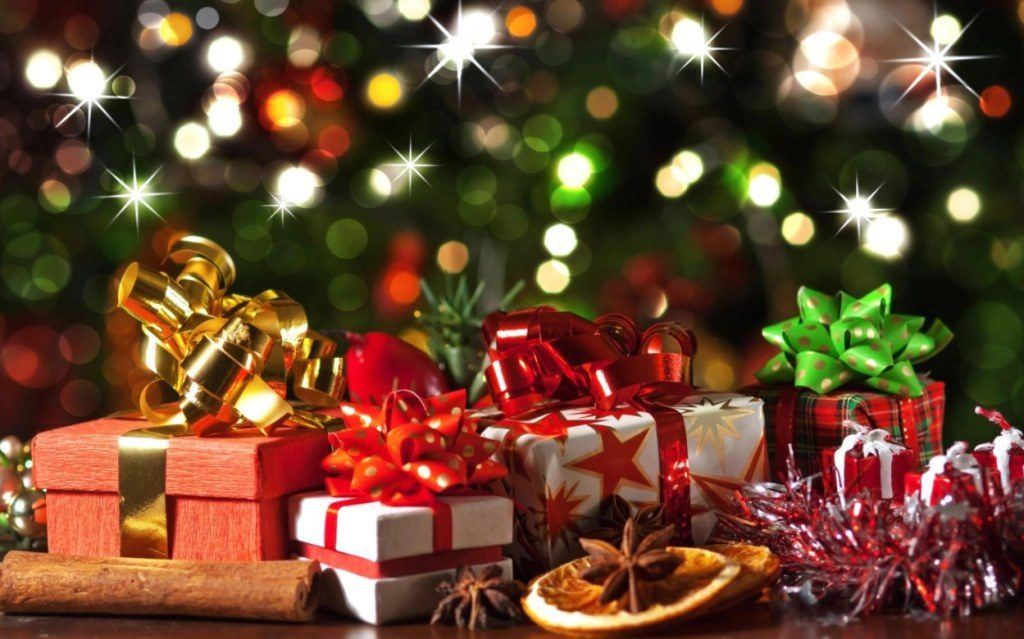

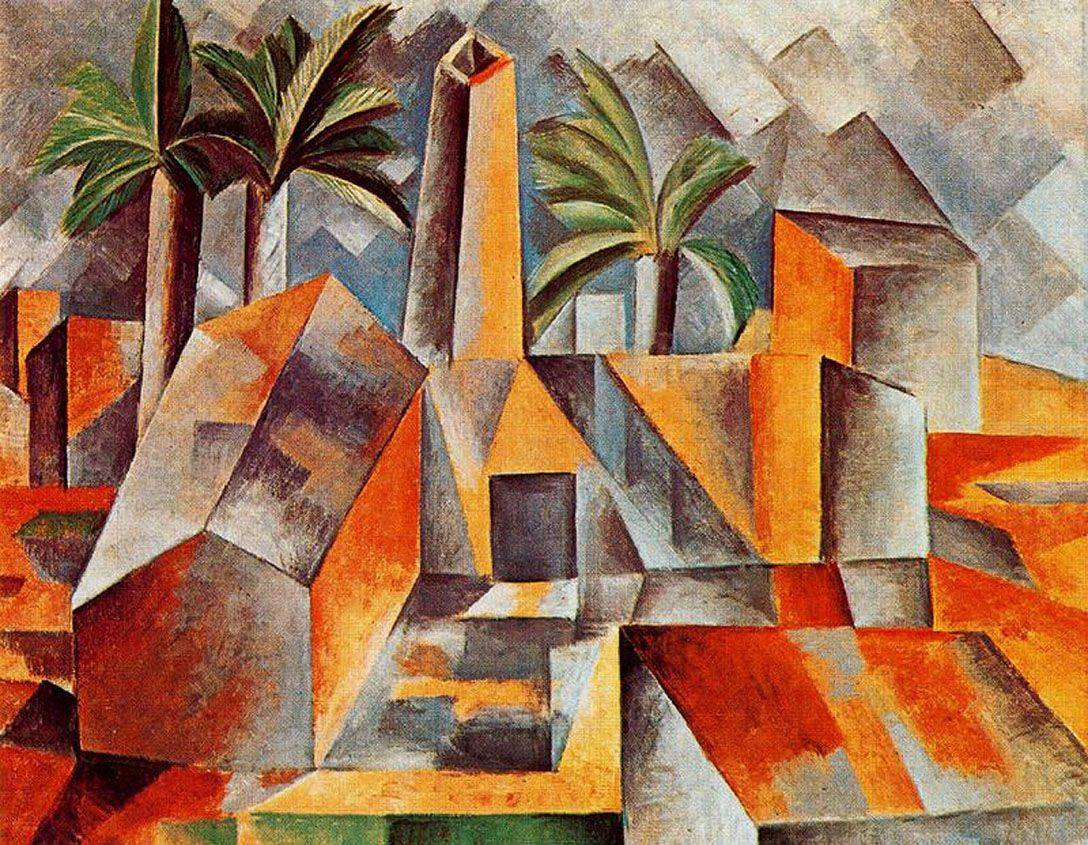

In [15]:
display(Image(base_image_path, width=500))
display(Image(style_reference_image_path, width=500))

### Image utilities

* Preprocessing

In [16]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

* Deprocessing

In [17]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### Compute the style transfer loss

* 4 utility functions

In [18]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

* A feature extraction model

In [19]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

* Computing code fragment

In [20]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

### Add a tf.function decorator

In [21]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

### The training loop

In [22]:
optimizer = keras.optimizers.SGD(
    ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=3997.12
Iteration 200: loss=3185.12
Iteration 300: loss=2835.09
Iteration 400: loss=2633.07
Iteration 500: loss=2499.23



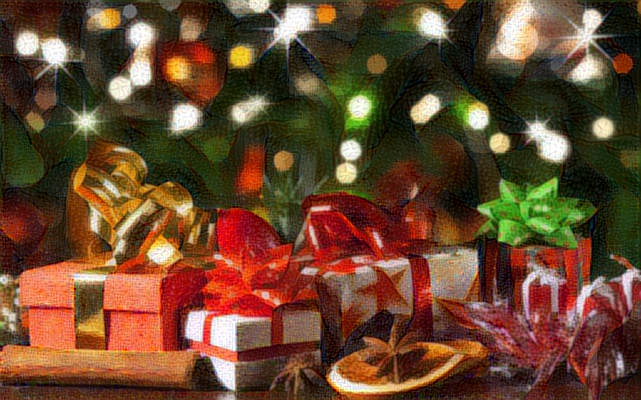

In [24]:
display(Image(result_prefix + "_at_iteration_500.png", width=500))